Convolutional Neural Network by Marlo Esperson


Raytheon Advisors: David Detienne and Kerry Courtright

Faculty Advisor: Alex Orange

Team Members: Josh Miraglia, Ryan Procarione, and Erik Graham

Last Update: 11.18.2021

The purpose of this program is to take in labeled generated signal data (bandwidth, center frequency, and signal-to-noise ratio (SNR)) from a Massive MIMO antenna and use it to train and test a convolutional neural network model that will be able to estimate bandwidth, center frequency, and SNR parameters.


Read in all signal data and labels:

In [14]:
#plotting function
%matplotlib notebook

In [15]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os

spec = 2048

M = 9999 # number of signals

with h5py.File("NNdataset.h5", "r") as f:
    folders = f.keys()
    #print("Folders in base: ", folders)
    
    L = f.get('labels') #Retrieves the "labels" folder.
    S = f.get('signals') #Retrieves "signals" folder.
    
    data = np.array(S.get('rx_signals'))
    dataset = data[0,0,:,:] #Sets the last two dimensions of the 4 dimensional array as the main 
                            #dataset
   

    print(L.keys())
    #print(dataset.shape)
    bandwidth = np.array(L.get('bandwidth'))
    centers = np.array(L.get('center_freq')) #TODO: include frequency in name
    SNR = np.array(L.get('SNR'))


MemoryError: Unable to allocate 14.6 GiB for an array with shape (24, 2, 10000, 2048) and data type complex128

# Move bandwidth labeled data into an array:

In [16]:

print(bandwidth[0:100])

[0.7169802 0.4155568 0.3947706 0.6541704 0.6336556 0.7549404 0.8662746
 0.8548934 0.46091   0.7086784 0.8848366 0.8546428 0.7185704 0.7625748
 0.2425308 0.281678  0.7711416 0.4612338 0.3638494 0.5555548 0.58814
 0.8111324 0.7489872 0.8264496 0.1484738 0.612306  0.7045478 0.4552022
 0.1729592 0.1306366 0.5145476 0.4611102 0.498249  0.2812358 0.7713936
 0.839939  0.4907508 0.2014836 0.636154  0.2676036 0.7589668 0.6070022
 0.5273686 0.280329  0.519343  0.175659  0.476017  0.8967204 0.3902764
 0.4707174 0.7830136 0.6116014 0.1076468 0.4827694 0.6548622 0.8472638
 0.6199848 0.5137802 0.274419  0.142675  0.1924622 0.6211234 0.2272264
 0.256888  0.414764  0.7227122 0.4202686 0.4950864 0.7095196 0.5912762
 0.570747  0.162056  0.412277  0.351006  0.7471448 0.7581736 0.3451234
 0.749653  0.198722  0.8276172 0.276461  0.5867446 0.8238436 0.3289206
 0.3133708 0.2157584 0.5892964 0.767287  0.6935018 0.3717132 0.879654
 0.6491056 0.166439  0.8063474 0.6776756 0.7659034 0.2546386 0.4486812
 0.156248

<IPython.core.display.Javascript object>


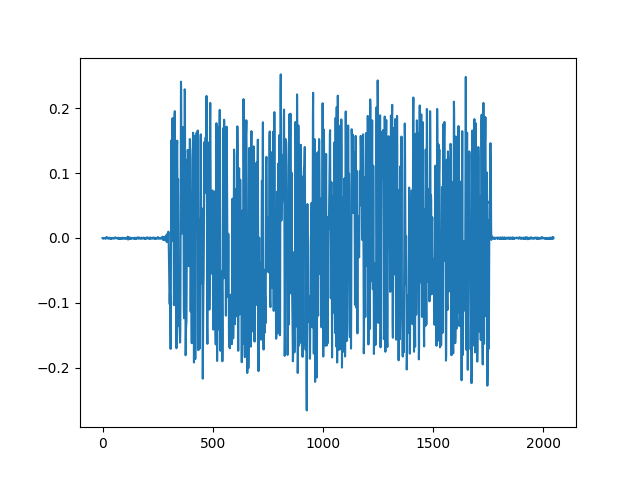

/users/MarloE/ve/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [17]:
plt.plot(dataset[1])


In [18]:
dataset_fft = abs(np.fft.fftshift(np.fft.fft(dataset), (1,))) #Pass this into NN.

<IPython.core.display.Javascript object>


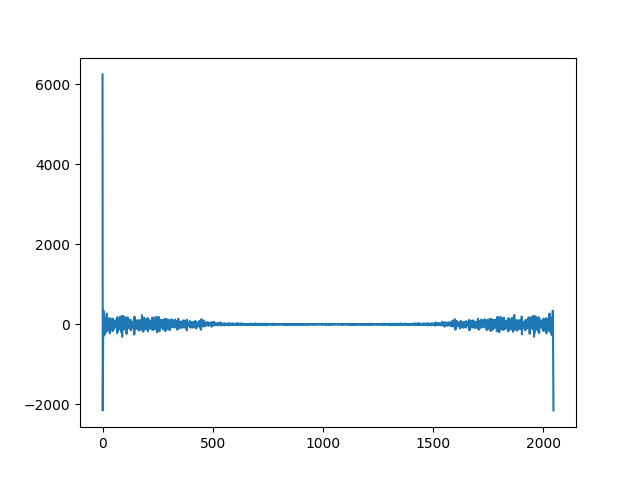

/users/MarloE/ve/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [19]:
plt.figure()
#plt.plot((np.fft.fft(dataset))[0])
#plt.show()
plt.plot((np.fft.fft(dataset_fft))[0])
plt.show()

<IPython.core.display.Javascript object>


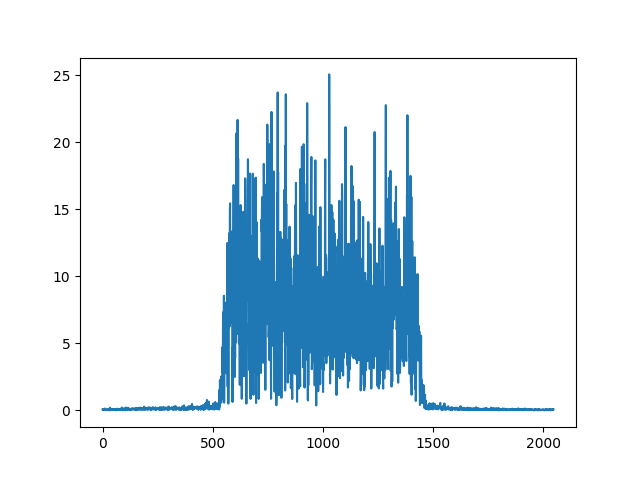

In [20]:
plt.figure()
plt.plot(dataset_fft[1])
plt.show()

Move center frequency labeled data into array:

In [21]:
#[1,2,3]*4

Move SNR labeled data into array:

In [22]:

#signal = dataset[M,:]
#x = np.linspace(0,2048,2048)

#print("test")
#print(dataset.shape)
#print(dataset.size())

    
#     G = f.get('dataset') #Retrieves "generated_data" file.
#     dataset = np.array(G.get('dataset')) #Retrieves contents of "dataset" folder
#     bandwidth = np.array(G.get('bandwidths')) #Retrieves contents of "bandwidths" folder
#     centers = np.array(G.get('center_freq')) #Retrieves "SNR" folder
#     #SNR = np.array(G.get('SNR'))    ????? Cannot upload NNDataset
#     signal = dataset[S,:]
#     x = np.linspace(0,2048,2048)

Signal Pre-Fourier Transform

In [23]:
#plt.plot(x,signal)
#plt.show() 

Signal Post-Fourier Transform

In [24]:
#plt.plot(np.abs(np.fft.fft(signal)))
#plt.show()

Splitting Dataset into Training and Testing Data

In [25]:
import os
num_threads = 24
os.environ["OMP_NUM_THREADS"] = "24"
os.environ["TF_NUM_INTRAOP_THREADS"] = "24"
os.environ["TF_NUM_INTEROP_THREADS"] = "24"

import tensorflow as tf

import tensorflow as tf
#config = tf.ConfigProto(intra_op_parallelism_threads=24,
#                        inter_op_parallelism_threads=2,
#                        allow_soft_placement=True,
#                        device_count = {'CPU': 24})
#session = tf.Session(config=config)
tf.config.threading.set_intra_op_parallelism_threads(24)
tf.config.threading.set_inter_op_parallelism_threads(24)
tf.config.set_soft_device_placement(True)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
import sys
import h5py
import random
import datetime

#Casts a list indexing from 0 to 9999 for each labeled dataset
#Bandwidth
#print(len(bandwidth))
idx_bw = list(range(len(bandwidth)))
#Center Frequency
#idx_cf = list(range(len(centers)))
#Signal-to-Noise Ratio
#idx_SNR = list(range(len(SNR)))

#TODO: Ask Josh about 2-Dimensional Numpy Array

#Shuffles indices of bandwidth, center freq, and SNR datasets
random.shuffle(idx_bw)
#random.shuffle(idx_cf)
#random.shuffle(idx_SNR)

#Splitting datasets (8000 assigned to training and 2000 to testing)
training_indices_bw, testing_indices_bw = np.split(idx_bw, [int(0.8*len(idx_bw))])
#training_indices_cf, testing_indices_cf = np.split(idx_cf, [int(0.8*len(idx_cf))])
#training_indices_SNR, testing_indices_SNR = np.split(idx_SNR, [int(0.8*len(idx_SNR))])

#initializing testing and training data and label arrays
training_data_bw = []
training_labels_bw = []

testing_data_bw = []
testing_labels_bw = []

# training_data_cf = []
# training_labels_cf = []

# testing_data_cf = []
# testing_labels_cf = []

# training_data_SNR = []
# training_labels_SNR = []

# testing_data_SNR = []
# testing_labels_SNR = []

#fill up training dataset and the associated bandwidths (splitting here)
for idx_bw in training_indices_bw:
    #iterate through all indices and print
    training_data_bw.append(dataset_fft[idx_bw])
    training_labels_bw.append(bandwidth[idx_bw])
    #print(idx)

    #put bandwidth training_data and training_labels into a numpy array.
training_data_bw = np.array(training_data_bw)
training_labels_bw = np.array(training_labels_bw)
   
for idx_bw in testing_indices_bw:
    testing_data_bw.append(dataset_fft[idx_bw])
    testing_labels_bw.append(bandwidth[idx_bw])


testing_data_bw = np.array(testing_data_bw)
testing_labels_bw = np.array(testing_labels_bw)


#fill up training dataset and the associated center frequency (splitting here)
# for idx_cf in training_indices_cf:
#     #iterate through all indices and print
#     training_data_cf.append(dataset[idx_cf])
#     training_labels_cf.append(bandwidth[idx_cf])
#     #print(idx)

#     #put bandwidth training_data and training_labels into a numpy array.
# training_data_cf = np.array(training_data_cf)
# training_labels_cf = np.array(training_labels_cf)
   
# for idx_cf in testing_indices_cf:
#     testing_data_cf.append(dataset[idx_cf])
#     testing_labels_cf.append(centers[idx_cf])


# testing_data_cf = np.array(testing_data_cf)
# testing_labels_cf = np.array(testing_labels_cf)


# for idx_SNR in training_indices_SNR:
#     #iterate through all indices and print
#     training_data_SNR.append(dataset[idx_SNR])
#     training_labels_SNR.append(SNR[idx_SNR])
#     #print(idx)

#     #put bandwidth training_data and training_labels into a numpy array.
# training_data_SNR = np.array(training_data_SNR)
# training_labels_SNR = np.array(training_labels_SNR)
   
# for idx_SNR in testing_indices_SNR:
#     testing_data_SNR.append(dataset[idx_SNR])
#     testing_labels_SNR.append(SNR[idx_SNR])


# testing_data_SNR = np.array(testing_data_SNR)
# testing_labels_SNR = np.array(testing_labels_SNR)

Network Structure (Topology)

In [26]:
from tensorflow.keras.optimizers import Adam

input = tf.keras.layers.Input(shape = (2048, 1)) #2 dimensions
#Conv1D(number of kernels (try as few as 4 and go up by factors of 2, NoMachine?),
#length of the kernel (per discussion on board, try around 300), relu may not be the best, try other activation functions)
layer1 = Conv1D(10, 50, activation='relu')(input)  
layer2 = MaxPooling1D(pool_size = (2))(layer1) #Look into different kind of pooling layers.
#Layer that will look for features that will take 2048 points and narrow down and find the index
#around the maximum points and around the maximum.
#TODO: Email Johnathan and ask about pool size recommendations. Also any recommendations beyond a MaxPooling layer.
layer3 = Flatten()(layer2) #10240 outputs
layer4 = Dense(320)(layer3)
layer5 = Dense(160)(layer4)
layer6 = Dense(64)(layer5) 
layer7 = Dense(1)(layer6) #output layer

model = tf.keras.models.Model(inputs = input, outputs = layer7)
model.summary()

#TODO: Experiment with learning rate
#model.compile(optimizer = "adam", #Johnathan Wintrode
#             loss='mean_squared_error')

model.compile(optimizer=Adam(learning_rate = 0.0001),
             loss='mean_squared_error')

#accuracy = Number of correct predictions / total number of predictions made

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2048, 1)]         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1999, 10)          510       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 999, 10)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9990)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 320)               3197120   
_________________________________________________________________
dense_5 (Dense)              (None, 160)               51360     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                1030

In [27]:
training_data_bw = tf.data.Dataset.from_tensor_slices(training_data_bw)
training_labels_bw = tf.data.Dataset.from_tensor_slices(training_labels_bw)
testing_data_bw = tf.data.Dataset.from_tensor_slices(testing_data_bw)
testing_labels_bw = tf.data.Dataset.from_tensor_slices(testing_labels_bw)

In [28]:
training_data_bw, training_labels_bw

(<TensorSliceDataset shapes: (2048,), types: tf.float64>,
 <TensorSliceDataset shapes: (), types: tf.float64>)

In [29]:
training_data = tf.data.Dataset.zip((training_data_bw, training_labels_bw))
print(training_data)
training_data = training_data.batch(128)
print(training_data)
training_data = training_data.cache()
print(training_data)
training_data = training_data.prefetch(tf.data.AUTOTUNE)
print(training_data)

testing_data = tf.data.Dataset.zip((testing_data_bw, testing_labels_bw))
testing_data = testing_data.batch(128)
testing_data = testing_data.cache()
testing_data = testing_data.prefetch(tf.data.AUTOTUNE)

training_data

<ZipDataset shapes: ((2048,), ()), types: (tf.float64, tf.float64)>
<BatchDataset shapes: ((None, 2048), (None,)), types: (tf.float64, tf.float64)>
<CacheDataset shapes: ((None, 2048), (None,)), types: (tf.float64, tf.float64)>
<PrefetchDataset shapes: ((None, 2048), (None,)), types: (tf.float64, tf.float64)>


<PrefetchDataset shapes: ((None, 2048), (None,)), types: (tf.float64, tf.float64)>

Training the Network

In [31]:
#training, default batch size is 1/32 of the dataset
#TODO: increase epochs later to see differences in loss and val_loss
#history = model.fit(training_data, training_labels, epochs = 10, validation_data = (testing_data, testing_labels), callbacks=[tensorboard_callback])
history = model.fit(training_data_bw, training_labels_bw, epochs = 2000, validation_data = (testing_data_bw, testing_labels_bw))

#How many epochs to perform?

loss = model.evaluate(testing_data_bw, testing_labels_bw, batch_size=128)
print("test loss, test acc:", loss)
print(loss)
print(history.history)

#mean square
loss = history.history['loss']
val_loss = history.history['val_loss']
#epochs = range(1,9)


#Root mean square
sqrt_loss = np.sqrt(loss)
sqrt_val_loss = np.sqrt(val_loss)

# plt.loglog(sqrt_loss, 'r', label='Training Loss')
# plt.loglog(sqrt_val_loss, 'b', label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

ValueError: `y` argument is not supported when using dataset as input.

In [ ]:
plt.figure()
plt.loglog(sqrt_loss, 'r', label='Training Loss')
plt.loglog(sqrt_val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Random integer input for checking random indices.

random_index = random.randint(0,len(testing_labels_bw)-1)


predict_bw = model.predict(testing_data_bw)

print(predict_bw[random_index])
print(testing_labels_bw[random_index])

In [19]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]